## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [2]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

Defaulting to user installation because normal site-packages is not writeable


/Users/ekaterinastepura/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


'items.csv'

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime

df_users = pd.read_csv('users.csv')
df_users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [5]:
df_items = pd.read_csv('items.csv')
df_items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [6]:
df_test = pd.read_csv('test.csv')
df_test

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0
...,...,...,...,...,...,...
608462,1035030,10201,2021-08-22,1154,19.0,0
608463,574452,2720,2021-08-22,9076,5.0,0
608464,700990,13865,2021-08-22,9010,100.0,1
608465,693510,7571,2021-08-22,3697,64.0,1


In [7]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866956 entries, 0 to 4866955
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 222.8+ MB


In [ ]:
df_train['last_watch_dt'] = pd.to_datetime(df_train['last_watch_dt'])
df_test['last_watch_dt'] = pd.to_datetime(df_test['last_watch_dt'])

In [ ]:
split_date = df_train['last_watch_dt'].quantile(0.8)  

In [9]:
print(split_date)

2021-07-26 00:00:00


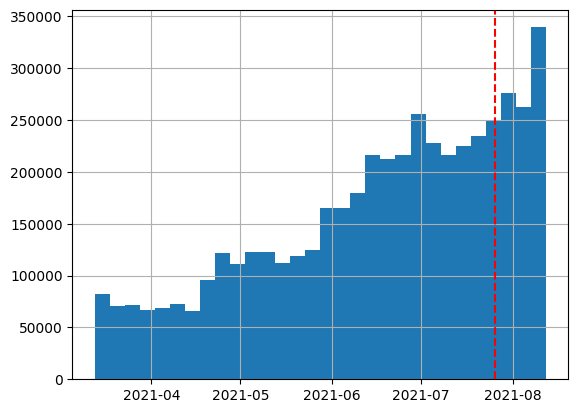

In [10]:
import matplotlib.pyplot as plt

df_train['last_watch_dt'].hist(bins=30)
plt.axvline(split_date, color='red', linestyle='--')
plt.show()

In [10]:
train_stage_1 = df_train[df_train['last_watch_dt'] < split_date]
valid_stage_1 = df_train[df_train['last_watch_dt'] >= split_date]



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [11]:
class PopularityRecommender:
    def __init__(self, top_n=50):
        self.top_n = top_n
        self.popular_items = None
    
    def fit(self, train_data):
        # Вычисляем популярность по количеству просмотров
        item_popularity = train_data.groupby('item_id')['target'].sum().reset_index()
        item_popularity.columns = ['item_id', 'score']
        self.popular_items = item_popularity.sort_values('score', ascending=False).head(self.top_n)
    
    def predict_score(self, user_id, item_id):
        if item_id in self.popular_items['item_id'].values:
            return self.popular_items[self.popular_items['item_id'] == item_id]['score'].values[0]
        return 0
    
    def recommend(self, user_id, k=10):
        return self.popular_items['item_id'].head(k).tolist()

my_heuristic_model = PopularityRecommender(top_n=100)
my_heuristic_model.fit(train_stage_1)

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset

class LightFMRecommender:
    def __init__(self, no_components=30):
        self.model = LightFM(no_components=no_components, loss='warp')
        self.dataset = None
        self.user_id_map = None
        self.item_id_map = None
    
    def fit(self, train_data, user_features, item_features):
        self.dataset = Dataset()
        
        train_users = train_data['user_id'].unique()
        train_items = train_data['item_id'].unique()
        
        user_features = user_features[user_features['user_id'].isin(train_users)]
        item_features = item_features[item_features['item_id'].isin(train_items)]
        
        user_feature_list = []
        for _, row in user_features.iterrows():
            if pd.notna(row['age']): user_feature_list.append(f"age:{row['age']}")
            if pd.notna(row['income']): user_feature_list.append(f"income:{row['income']}")
            if pd.notna(row['sex']): user_feature_list.append(f"sex:{row['sex']}")
            if pd.notna(row['kids_flg']): user_feature_list.append(f"kids:{int(row['kids_flg'])}")
        
        item_feature_list = []
        for _, row in item_features.iterrows():
            if pd.notna(row['genres']):
                for genre in row['genres'].split(', '):
                    item_feature_list.append(f"genre:{genre.strip()}")
            if pd.notna(row['countries']):
                for country in row['countries'].split(', '):
                    item_feature_list.append(f"country:{country.strip()}")
            if pd.notna(row['age_rating']): 
                item_feature_list.append(f"age_rating:{int(row['age_rating'])}")
        
        self.dataset.fit(users=train_users,
                        items=train_items,
                        user_features=set(user_feature_list),
                        item_features=set(item_feature_list))
        
        user_features_list = []
        for _, row in user_features.iterrows():
            features = []
            if pd.notna(row['age']): features.append(f"age:{row['age']}")
            if pd.notna(row['income']): features.append(f"income:{row['income']}")
            if pd.notna(row['sex']): features.append(f"sex:{row['sex']}")
            if pd.notna(row['kids_flg']): features.append(f"kids:{int(row['kids_flg'])}")
            user_features_list.append((row['user_id'], features))
        
        item_features_list = []
        for _, row in item_features.iterrows():
            features = []
            if pd.notna(row['genres']):
                for genre in row['genres'].split(', '):
                    features.append(f"genre:{genre.strip()}")
            if pd.notna(row['countries']):
                for country in row['countries'].split(', '):
                    features.append(f"country:{country.strip()}")
            if pd.notna(row['age_rating']):
                features.append(f"age_rating:{int(row['age_rating'])}")
            item_features_list.append((row['item_id'], features))
        
        user_features_matrix = self.dataset.build_user_features(user_features_list)
        item_features_matrix = self.dataset.build_item_features(item_features_list)
        
        (interactions, weights) = self.dataset.build_interactions(
            [(row['user_id'], row['item_id'], row['target']) 
             for _, row in train_data.iterrows()])
        
        self.model.fit(interactions, 
                      user_features=user_features_matrix,
                      item_features=item_features_matrix,
                      epochs=20)
        
        self.user_id_map, _, self.item_id_map, _ = self.dataset.mapping()
    
    def predict_score(self, user_id, item_id):
        try:
            user_idx = self.user_id_map[user_id]
            item_idx = self.item_id_map[item_id]
            return self.model.predict(user_idx, [item_idx])[0]
        except KeyError:
            return 0
    
    def recommend(self, user_id, k=10):
        try:
            user_idx = self.user_id_map[user_id]
            all_items = list(self.item_id_map.values())
            scores = self.model.predict(user_idx, all_items)
            top_items = np.argsort(-scores)[:k]
            return [list(self.item_id_map.keys())[list(self.item_id_map.values()).index(i)] for i in top_items]
        except KeyError:
            return []

my_matrix_factorization = LightFMRecommender()
my_matrix_factorization.fit(train_stage_1, df_users, df_items)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

class TwoTowerRecommender:
    def __init__(self, embedding_dim=64):
        self.embedding_dim = embedding_dim
        self.model = None
        self.user_encoder = None
        self.item_encoder = None
        self.user_features = None
        self.item_features = None
        
        self.age_map = {}
        self.income_map = {}
        self.sex_map = {}
        self.genre_map = {}
        self.country_map = {}
    
    def _prepare_mappings(self, user_features, item_features):
        ages = user_features['age'].dropna().unique()
        self.age_map = {v: i+1 for i, v in enumerate(ages)} 
        
        incomes = user_features['income'].dropna().unique()
        self.income_map = {v: i+1 for i, v in enumerate(incomes)}
        
        sexes = user_features['sex'].dropna().unique()
        self.sex_map = {v: i+1 for i, v in enumerate(sexes)}
        
        genre_vocab = set()
        country_vocab = set()
        for genres in item_features['genres'].dropna():
            genre_vocab.update(genres.split(', '))
        for countries in item_features['countries'].dropna():
            country_vocab.update(countries.split(', '))
            
        self.genre_map = {v: i+1 for i, v in enumerate(genre_vocab)}
        self.country_map = {v: i+1 for i, v in enumerate(country_vocab)}
    
    def fit(self, train_data, user_features, item_features):
        self.user_features = user_features.set_index('user_id')
        self.item_features = item_features.set_index('item_id')
        
        self._prepare_mappings(user_features, item_features)
        
        user_input = Input(shape=(4,), name='user_input')
        age_embed = Embedding(len(self.age_map)+1, self.embedding_dim)(user_input[:, 0])
        income_embed = Embedding(len(self.income_map)+1, self.embedding_dim)(user_input[:, 1])
        sex_embed = Embedding(len(self.sex_map)+1, self.embedding_dim)(user_input[:, 2])
        kids_embed = Embedding(2, self.embedding_dim)(user_input[:, 3])
        
        user_vec = Concatenate()([
            Flatten()(age_embed), 
            Flatten()(income_embed), 
            Flatten()(sex_embed), 
            Flatten()(kids_embed)
        ])
        user_vec = Dense(self.embedding_dim, activation='relu')(user_vec)
        
        item_input = Input(shape=(3,), name='item_input')
        genres_embed = Embedding(len(self.genre_map)+1, self.embedding_dim)(item_input[:, 0])
        countries_embed = Embedding(len(self.country_map)+1, self.embedding_dim)(item_input[:, 1])
        age_rating_embed = Embedding(21, self.embedding_dim)(item_input[:, 2])  
        
        item_vec = Concatenate()([
            Flatten()(genres_embed), 
            Flatten()(countries_embed), 
            Flatten()(age_rating_embed)
        ])
        item_vec = Dense(self.embedding_dim, activation='relu')(item_vec)
        
        dot_product = tf.keras.layers.Dot(axes=1)([user_vec, item_vec])
        output = Dense(1, activation='sigmoid')(dot_product)
        
        self.model = Model(inputs=[user_input, item_input], outputs=output)
        self.model.compile(optimizer='adam', loss='binary_crossentropy')
        
        self.user_encoder = Model(inputs=user_input, outputs=user_vec)
        self.item_encoder = Model(inputs=item_input, outputs=item_vec)
        
        X_user, X_item, y = [], [], []
        for _, row in train_data.iterrows():
            user_id = row['user_id']
            item_id = row['item_id']
            
            if user_id in self.user_features.index and item_id in self.item_features.index:
                user_row = self.user_features.loc[user_id]
                item_row = self.item_features.loc[item_id]
                
                age_idx = self.age_map.get(user_row['age'], 0)
                income_idx = self.income_map.get(user_row['income'], 0)
                sex_idx = self.sex_map.get(user_row['sex'], 0)
                kids_flg = int(user_row['kids_flg']) if pd.notna(user_row['kids_flg']) else 0
                
                genres = item_row['genres'].split(', ')[0] if pd.notna(item_row['genres']) else ''
                countries = item_row['countries'].split(', ')[0] if pd.notna(item_row['countries']) else ''
                genre_idx = self.genre_map.get(genres, 0)
                country_idx = self.country_map.get(countries, 0)
                age_rating = min(int(item_row['age_rating']), 20) if pd.notna(item_row['age_rating']) else 0 
                
                X_user.append([age_idx, income_idx, sex_idx, kids_flg])
                X_item.append([genre_idx, country_idx, age_rating])
                y.append(row['target'])
        
        X_user = np.array(X_user)
        X_item = np.array(X_item)
        y = np.array(y)
        
        self.model.fit([X_user, X_item], y, 
                      batch_size=256, epochs=10, validation_split=0.1)
    
    def predict_score(self, user_ids, item_ids):
        user_features = []
        item_features = []
        valid_indices = []  
        
        for i, (user_id, item_id) in enumerate(zip(user_ids, item_ids)):
            try:
                user_row = self.user_features.loc[user_id]
                item_row = self.item_features.loc[item_id]
                
                age_idx = self.age_map.get(user_row['age'], 0)
                income_idx = self.income_map.get(user_row['income'], 0)
                sex_idx = self.sex_map.get(user_row['sex'], 0)
                kids_flg = int(user_row['kids_flg']) if pd.notna(user_row['kids_flg']) else 0
                
                genres = item_row['genres'].split(', ')[0] if pd.notna(item_row['genres']) else ''
                countries = item_row['countries'].split(', ')[0] if pd.notna(item_row['countries']) else ''
                genre_idx = self.genre_map.get(genres, 0)
                country_idx = self.country_map.get(countries, 0)
                age_rating = min(int(item_row['age_rating']), 20) if pd.notna(item_row['age_rating']) else 0
                
                user_features.append([age_idx, income_idx, sex_idx, kids_flg])
                item_features.append([genre_idx, country_idx, age_rating])
                valid_indices.append(i)
            except KeyError:
                continue
        
        if not valid_indices:
            return np.full(len(user_ids), 0.5) 
        
        user_features = np.array(user_features)
        item_features = np.array(item_features)
        
        batch_size = 1024 
        predictions = []
        
        for i in range(0, len(user_features), batch_size):
            batch_user = user_features[i:i+batch_size]
            batch_item = item_features[i:i+batch_size]
            batch_pred = self.model.predict([batch_user, batch_item], verbose=0).flatten()
            predictions.extend(batch_pred)
        
        result = np.full(len(user_ids), 0.5)
        result[valid_indices] = predictions
        
        return result
    
    def recommend(self, user_id, k=10):
        try:
            user_row = self.user_features.loc[user_id]
            
            age_idx = self.age_map.get(user_row['age'], 0)
            income_idx = self.income_map.get(user_row['income'], 0)
            sex_idx = self.sex_map.get(user_row['sex'], 0)
            kids_flg = int(user_row['kids_flg']) if pd.notna(user_row['kids_flg']) else 0
            
            user_vec = self.user_encoder.predict(np.array([[age_idx, income_idx, sex_idx, kids_flg]]))
            
            all_items = []
            item_vectors = []
            for item_id, item_row in self.item_features.iterrows():
                genres = item_row['genres'].split(', ')[0] if pd.notna(item_row['genres']) else ''
                countries = item_row['countries'].split(', ')[0] if pd.notna(item_row['countries']) else ''
                genre_idx = self.genre_map.get(genres, 0)
                country_idx = self.country_map.get(countries, 0)
                age_rating = min(int(item_row['age_rating']), 20) if pd.notna(item_row['age_rating']) else 0  
                
                item_vec = self.item_encoder.predict(np.array([[genre_idx, country_idx, age_rating]]))
                all_items.append(item_id)
                item_vectors.append(item_vec)
            
            item_vectors = np.array(item_vectors).squeeze()
            scores = np.dot(item_vectors, user_vec.T).flatten()
            top_k = np.argsort(-scores)[:k]
            return [all_items[i] for i in top_k]
        except KeyError:
            return []

my_neural_network = TwoTowerRecommender(embedding_dim=64)
my_neural_network.fit(train_stage_1, df_users, df_items)

/Users/ekaterinastepura/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 12s 986us/step - loss: 0.6652 - val_loss: 0.6577
Epoch 2/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 11s 956us/step - loss: 0.6558 - val_loss: 0.6532
Epoch 3/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6548 - val_loss: 0.6602
Epoch 4/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 11s 996us/step - loss: 0.6545 - val_loss: 0.6609
Epoch 5/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6541 - val_loss: 0.6578
Epoch 6/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6538 - val_loss: 0.6594
Epoch 7/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 11s 972us/step - loss: 0.6535 - val_loss: 0.6558
Epoch 8/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6532 - val_loss: 0.6610
Epoch 9/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.6536 - val_loss: 0.6604
Epoch 10/10
11109/11109 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6533 - val_loss: 0.6546


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [ ]:
def generate_features(data, target_date, train_data):
    historical_data = train_data[train_data['last_watch_dt'] < target_date]
    
    data = data.merge(df_users, on='user_id', how='left')
    data = data.merge(df_items, on='item_id', how='left')
    
    # 1. Признаки пользователя (2 признака)
    user_stats = historical_data.groupby('user_id').agg({
        'total_dur': 'mean',  # Средняя продолжительность просмотра
        'target': 'mean'       # Доля просмотров до конца
    }).rename(columns={
        'total_dur': 'user_mean_duration',
        'target': 'user_completion_rate'
    }).reset_index()
    
    # 2. Признаки айтема (2 признака)
    item_stats = historical_data.groupby('item_id').agg({
        'total_dur': 'mean',  # Средняя продолжительность просмотра
        'target': 'mean'      # Доля просмотров до конца
    }).rename(columns={
        'total_dur': 'item_mean_duration',
        'target': 'item_completion_rate'
    }).reset_index()
    
    # 3. Признаки взаимодействия пользователь-айтем (6 признаков)
    
    # a) Соответствие возраста пользователя и возрастного рейтинга айтема
    data['age_rating_match'] = np.where(
        (data['age'].isin(['age_18_24', 'age_25_34'])) & (data['age_rating'] <= 16), 1,
        np.where(
            (data['age'].isin(['age_35_44', 'age_45_54'])) & (data['age_rating'] <= 18), 1,
            np.where(
                (data['age'].isin(['age_55_64', 'age_65_inf'])) & (data['age_rating'] <= 21), 1,
                0
            )
        )
    )
    
    # b) Средний процент просмотра айтемов этого жанра пользователем
    genre_interaction = historical_data.merge(
        df_items[['item_id', 'genres']], 
        on='item_id', how='left'
    )
    genre_interaction['genres'] = genre_interaction['genres'].str.split(', ')
    genre_interaction = genre_interaction.explode('genres')
    
    user_genre_stats = genre_interaction.groupby(['user_id', 'genres']).agg({
        'watched_pct': 'mean'
    }).reset_index().rename(columns={'watched_pct': 'user_genre_watch_pct'})
    
    data['primary_genre'] = data['genres'].str.split(', ').str[0]
    
    data = data.merge(
        user_genre_stats.rename(columns={'genres': 'primary_genre'}),
        on=['user_id', 'primary_genre'],
        how='left'
    ).rename(columns={'user_genre_watch_pct': 'user_item_genre_match'})
    
    # c) Средний процент просмотра айтемов этой страны пользователем
    country_interaction = historical_data.merge(
        df_items[['item_id', 'countries']], 
        on='item_id', how='left'
    )
    country_interaction['countries'] = country_interaction['countries'].str.split(', ')
    country_interaction = country_interaction.explode('countries')
    
    user_country_stats = country_interaction.groupby(['user_id', 'countries']).agg({
        'watched_pct': 'mean'
    }).reset_index().rename(columns={'watched_pct': 'user_country_watch_pct'})
    
    data['primary_country'] = data['countries'].str.split(', ').str[0]
    
    data = data.merge(
        user_country_stats.rename(columns={'countries': 'primary_country'}),
        on=['user_id', 'primary_country'],
        how='left'
    ).rename(columns={'user_country_watch_pct': 'user_item_country_match'})
    
    # d) Соответствие наличия детей у пользователя и метки for_kids у айтема
    data['kids_match'] = np.where(
        (data['kids_flg'] == 1) & (data['for_kids'] == 1), 1,
        np.where(
            (data['kids_flg'] == 0) & (data['for_kids'] == 0), 1,
            0
        )
    )
    
    # e) Взаимодействие пола пользователя и жанра айтема (если есть столбец 'sex')
    if 'sex' in data.columns:
        sex_genre_stats = genre_interaction.merge(
            df_users[['user_id', 'sex']], 
            on='user_id', how='left'
        ).groupby(['sex', 'genres']).agg({
            'watched_pct': 'mean'
        }).reset_index().rename(columns={'watched_pct': 'sex_genre_watch_pct'})
        
        data = data.merge(
            sex_genre_stats.rename(columns={'genres': 'primary_genre'}),
            on=['sex', 'primary_genre'],
            how='left'
        ).rename(columns={'sex_genre_watch_pct': 'sex_genre_match'})
    else:
        data['sex_genre_match'] = 0.5 
    
    # f) Взаимодействие возраста пользователя и жанра айтема
    age_genre_stats = genre_interaction.merge(
        df_users[['user_id', 'age']], 
        on='user_id', how='left'
    ).groupby(['age', 'genres']).agg({
        'watched_pct': 'mean'
    }).reset_index().rename(columns={'watched_pct': 'age_genre_watch_pct'})
    
    data = data.merge(
        age_genre_stats.rename(columns={'genres': 'primary_genre'}),
        on=['age', 'primary_genre'],
        how='left'
    ).rename(columns={'age_genre_watch_pct': 'age_genre_match'})
    
    data = data.merge(user_stats, on='user_id', how='left')
    data = data.merge(item_stats, on='item_id', how='left')
    
    for col in ['user_mean_duration', 'user_completion_rate', 
               'item_mean_duration', 'item_completion_rate',
               'user_item_genre_match', 'user_item_country_match',
               'sex_genre_match', 'age_genre_match']:
        if col in data.columns:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = 0.5
    
    cols_to_drop = ['age', 'age_rating', 'genres', 'primary_genre', 
                   'countries', 'primary_country', 'kids_flg', 'for_kids']
    if 'sex' in data.columns:
        cols_to_drop.append('sex')
    
    data = data.drop(cols_to_drop, axis=1, errors='ignore')
    
    return data

In [64]:
valid_start_date = valid_stage_1['last_watch_dt'].min()
test_start_date = df_test['last_watch_dt'].min()

train_df_with_features = generate_features(valid_stage_1.copy(), valid_start_date, train_stage_1)
test_df_with_features = generate_features(df_test.copy(), test_start_date, pd.concat([train_stage_1, valid_stage_1]))

print("Сгенерированные признаки:")
print(train_df_with_features.columns.tolist())
print("\nПример данных:")
print(train_df_with_features.head())

Сгенерированные признаки:
['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target', 'income', 'content_type', 'title', 'title_orig', 'release_year', 'studios', 'directors', 'actors', 'description', 'keywords', 'age_rating_match', 'user_item_genre_match', 'user_item_country_match', 'kids_match', 'sex_genre_match', 'age_genre_match', 'user_mean_duration', 'user_completion_rate', 'item_mean_duration', 'item_completion_rate']

Пример данных:
   user_id  item_id last_watch_dt  total_dur  watched_pct  target  \
0  1076667     2954    2021-07-26        742         14.0       0   
1  1060329    11348    2021-07-26       4004         54.0       1   
2   978215     4633    2021-07-26       2196         33.0       0   
3   316890    10440    2021-07-26      11349         50.0       0   
4   288774     7829    2021-07-26        880         13.0       0   

         income content_type  \
0  income_20_40         film   
1           NaN         film   
2  income_20_40       serie


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [ ]:
import numpy as np
from tqdm import tqdm

def add_all_model_scores(data, heuristic_model, mf_model, nn_model, batch_size=1024):
    result = data.copy()
    
    print("Adding heuristic scores...")
    result['heuristic_score'] = [heuristic_model.predict_score(row['user_id'], row['item_id']) 
                               for _, row in tqdm(data.iterrows(), total=len(data))]
    
    print("\nAdding matrix factorization scores...")
    
    user_indices = []
    item_indices = []
    valid_indices = []
    
    for idx, row in tqdm(data.iterrows(), total=len(data)):
        try:
            user_idx = mf_model.user_id_map[row['user_id']]
            item_idx = mf_model.item_id_map[row['item_id']]
            user_indices.append(user_idx)
            item_indices.append(item_idx)
            valid_indices.append(idx)
        except KeyError:
            continue
    
    if user_indices:
        mf_scores = mf_model.model.predict(
            np.array(user_indices),
            np.array(item_indices),
            num_threads=4
        )
        result.loc[valid_indices, 'mf_score'] = mf_scores
    
    result['mf_score'] = result['mf_score'].fillna(0)
    
    print("\nAdding neural network scores...")
    
    user_features = []
    item_features = []
    valid_indices = []
    
    for idx, row in tqdm(data.iterrows(), total=len(data)):
        try:
            user_row = nn_model.user_features.loc[row['user_id']]
            item_row = nn_model.item_features.loc[row['item_id']]
            
            age_idx = nn_model.age_map.get(user_row['age'], 0)
            income_idx = nn_model.income_map.get(user_row['income'], 0)
            sex_idx = nn_model.sex_map.get(user_row['sex'], 0)
            kids_flg = int(user_row['kids_flg']) if pd.notna(user_row['kids_flg']) else 0
            
            genres = item_row['genres'].split(', ')[0] if pd.notna(item_row['genres']) else ''
            countries = item_row['countries'].split(', ')[0] if pd.notna(item_row['countries']) else ''
            genre_idx = nn_model.genre_map.get(genres, 0)
            country_idx = nn_model.country_map.get(countries, 0)
            age_rating = min(int(item_row['age_rating']), 20) if pd.notna(item_row['age_rating']) else 0
            
            user_features.append([age_idx, income_idx, sex_idx, kids_flg])
            item_features.append([genre_idx, country_idx, age_rating])
            valid_indices.append(idx)
        except KeyError:
            continue
    
    if user_features:
        user_features = np.array(user_features)
        item_features = np.array(item_features)
        nn_scores = []
        
        for i in tqdm(range(0, len(user_features), batch_size), 
                     total=len(user_features)//batch_size + 1):
            batch_user = user_features[i:i+batch_size]
            batch_item = item_features[i:i+batch_size]
            batch_pred = nn_model.model.predict([batch_user, batch_item], verbose=0).flatten()
            nn_scores.extend(batch_pred)
        
        result.loc[valid_indices, 'nn_score'] = nn_scores
    
    result['nn_score'] = result['nn_score'].fillna(0.5)
    
    return result

In [ ]:
train_df_with_scores = add_all_model_scores(
    train_df_with_features,  
    my_heuristic_model,      
    my_matrix_factorization, 
    my_neural_network,    
    batch_size=2048        
)

Adding heuristic scores...


100%|██████████| 975216/975216 [00:49<00:00, 19729.25it/s]



Adding matrix factorization scores...


100%|██████████| 975216/975216 [00:15<00:00, 63442.76it/s]



Adding neural network scores...


100%|██████████| 384/384 [00:18<00:00, 20.69it/s]


In [ ]:
test_df_with_scores = add_all_model_scores(
    test_df_with_features, 
    my_heuristic_model,
    my_matrix_factorization,
    my_neural_network,
    batch_size=2048
)


Adding heuristic scores...


100%|██████████| 608467/608467 [00:28<00:00, 21419.98it/s]



Adding matrix factorization scores...


100%|██████████| 608467/608467 [00:09<00:00, 64284.98it/s]



Adding neural network scores...


100%|██████████| 235/235 [00:11<00:00, 20.88it/s]


In [60]:
print("Train data with scores:")
print(train_df_with_scores[['user_id', 'item_id', 'heuristic_score', 'mf_score', 'nn_score']].head())
print("\nTest data with scores:")
print(test_df_with_scores[['user_id', 'item_id', 'heuristic_score', 'mf_score', 'nn_score']].head())

Train data with scores:
   user_id  item_id  heuristic_score  mf_score  nn_score
0  1076667     2954                0  2.460977  0.574011
1  1060329    11348                0  1.707993  0.500000
2   978215     4633                0  0.726028  0.087513
3   316890    10440            65936  0.000000  0.500000
4   288774     7829             3516  4.341522  0.554920

Test data with scores:
   user_id  item_id  heuristic_score  mf_score  nn_score
0   718866     6382                0  2.170987  0.425476
1   147119    13865            66747  0.000000  0.590040
2  1079425     4141                0 -1.758419  0.366084
3   810008    15297            78653  0.000000  0.500000
4  1068123    10440            65936  0.000000  0.523214


In [87]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

train_df = train_with_scores
test_df = test_with_scores

X = train_df.drop(['user_id', 'item_id', 'target'], axis=1)
y = train_df['target']

X_test = test_df.drop(['user_id', 'item_id', 'target'], axis=1)
y_test = test_df['target']

cat_features = list(X.select_dtypes(include=['object']).columns)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='AUC',
    random_seed=42,
    cat_features=cat_features,
    early_stopping_rounds=50,
    verbose=100
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    plot=True
)

test_predictions = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nTest AUC: {test_auc:.4f}")

train_users = set(train_df['user_id'])
test_df['user_type'] = test_df['user_id'].apply(
    lambda x: 'cold' if x not in train_users else 'warm')

cold_mask = test_df['user_type'] == 'cold'
warm_mask = test_df['user_type'] == 'warm'

cold_auc = roc_auc_score(y_test[cold_mask], test_predictions[cold_mask])
warm_auc = roc_auc_score(y_test[warm_mask], test_predictions[warm_mask])

print(f"Cold users AUC: {cold_auc:.4f}")
print(f"Warm users AUC: {warm_auc:.4f}")

feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature Id'][:20], 
        feature_importance['Importances'][:20])
plt.title('Top 20 Feature Importance')
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Визуализация
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)
shap.summary_plot(shap_values, X_train, plot_type="dot", max_display=20)

max_imp = feature_importance['Importances'].max()
mean_imp = feature_importance['Importances'].mean()

model.save_model('final_ranker.cbm')

submission = test_df[['user_id', 'item_id']].copy()
submission['target'] = test_predictions
submission.to_csv('submission.csv', index=False)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [86]:
!pip install --upgrade pip
!pip install numpy==1.24.4 catboost==1.2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached catboost-1.2-cp39-cp39-macosx_11_0_universal2.whl.metadata (1.2 kB)
Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl (13.9 MB)
Using cached catboost-1.2-cp39-cp39-macosx_11_0_universal2.whl (25.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


У меня, к сожалению возникла проблема с библиотекой catboost, которую я не смогла решить за это время, но в другой среде все работало.


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!